# Comparative Analysis of Hierarchical Graph RAG vs Graph RAG
#### Amrutha M, Bhargava Srinivasan

## Install Required Packages

In [1]:
!pip install networkx torch numpy matplotlib transformers datasets faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Import Required Libraries

In [2]:
import networkx as nx
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score

## Import DistilBERT Model and Tokenizer

In [7]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Sample Documents for generation of vector representations

In [5]:
documents = [
    "Artificial intelligence is the simulation of human intelligence in machines.",
    "Deep learning is a subset of machine learning that uses neural networks.",
    "Natural language processing allows computers to understand and process human language.",
    "Computer vision is a field of AI that focuses on enabling computers to interpret visual information.",
    "Reinforcement learning is a type of machine learning where agents learn by interacting with the environment.",
    "Machine learning is a method of data analysis that automates analytical model building.",
    "AI ethics focuses on the ethical implications and challenges of artificial intelligence.",
    "Autonomous vehicles rely heavily on computer vision and deep learning for navigation.",
    "Quantum computing uses quantum-mechanical phenomena to perform operations on data.",
    "Speech recognition technology enables machines to understand spoken language.",
    "Image segmentation is used in computer vision for object detection.",
    "Machine translation converts text from one language to another.",
    "Recommendation systems suggest products or content to users based on their preferences."
]

## Embed Documents Using DistilBERT

In [8]:
def embed_documents(documents):
    embeddings = []
    for doc in documents:
        inputs = tokenizer(doc, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            # Get the embedding of the [CLS] token (representative of the entire document)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return np.array(embeddings)

embeddings = embed_documents(documents)

## Build Knowledge Graph

In [9]:
# Step 3: Build the Knowledge Graph
def build_knowledge_graph(embeddings, documents, similarity_threshold=0.7):
    G = nx.Graph()

    # Add nodes with document content
    for i, doc in enumerate(documents):
        G.add_node(i, content=doc)

    # Compute cosine similarities and add edges based on similarity threshold
    sim_matrix = cosine_similarity(embeddings)
    for i in range(len(documents)):
        for j in range(i+1, len(documents)):  # Avoid self-links and duplicate edges
            sim = sim_matrix[i, j]
            if sim > similarity_threshold:
                G.add_edge(i, j, weight=sim)

    return G

# Build the graph
G = build_knowledge_graph(embeddings, documents)


## Display Graph Details

Number of nodes: 13
Number of edges: 72
Sample nodes and edges:
[(0, {'content': 'Artificial intelligence is the simulation of human intelligence in machines.'}), (1, {'content': 'Deep learning is a subset of machine learning that uses neural networks.'})]
[(0, 1, {'weight': 0.8750864}), (0, 2, {'weight': 0.88030285})]



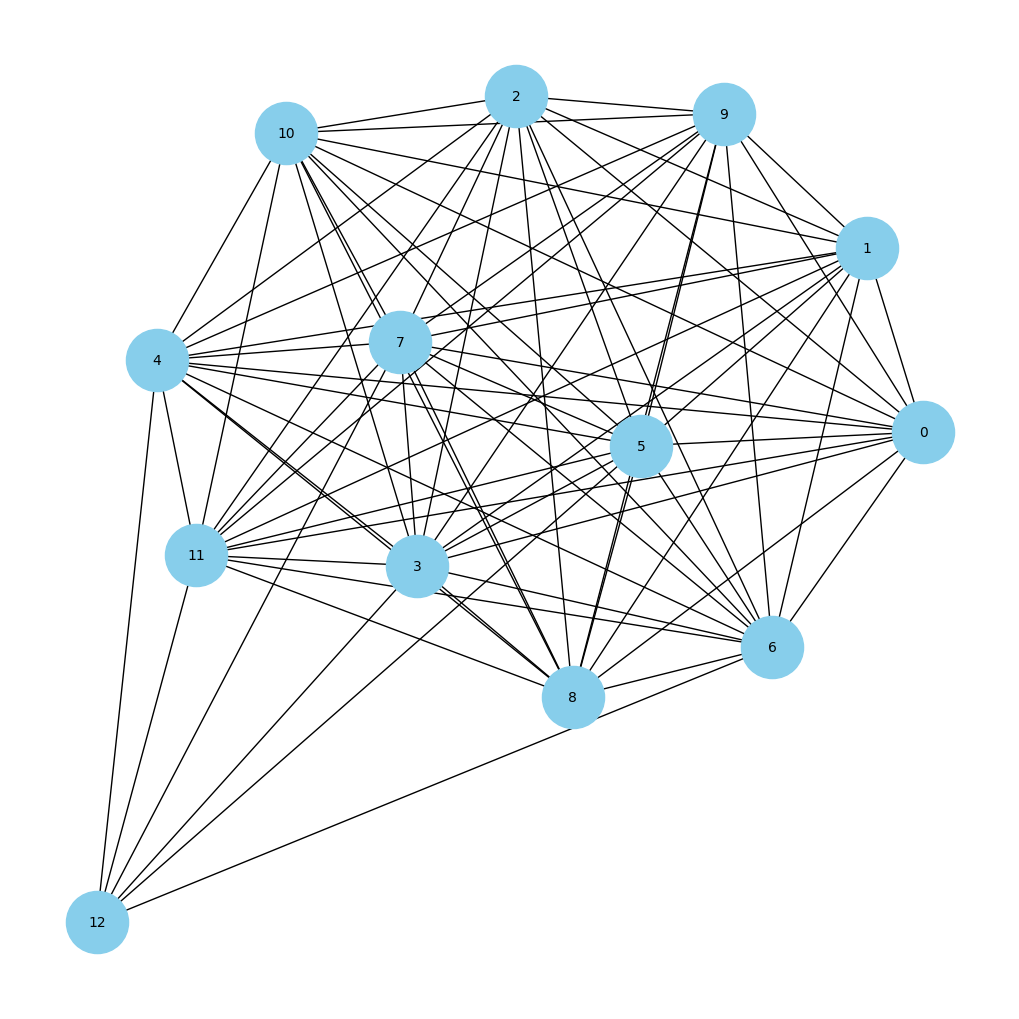

In [10]:
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")
print("Sample nodes and edges:")
print(list(G.nodes(data=True))[:2])  # Print first 2 nodes with their attributes
print(list(G.edges(data=True))[:2])  # Print first 2 edges with their weights

print()

import matplotlib.pyplot as plt

# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=2000, node_color='skyblue', font_size=10)
plt.show()


## Expanded Dataset for Performance Testing

In [11]:
documents = [
    "Artificial intelligence is the simulation of human intelligence in machines.",
    "Deep learning is a subset of machine learning that uses neural networks.",
    "Natural language processing allows computers to understand and process human language.",
    "Computer vision is a field of AI that focuses on enabling computers to interpret visual information.",
    "Reinforcement learning is a type of machine learning where agents learn by interacting with the environment.",
    "Machine learning is a method of data analysis that automates analytical model building.",
    "AI ethics focuses on the ethical implications and challenges of artificial intelligence.",
    "Autonomous vehicles rely heavily on computer vision and deep learning for navigation.",
    "Quantum computing uses quantum-mechanical phenomena to perform operations on data.",
    "Speech recognition technology enables machines to understand spoken language.",
    "Image segmentation is used in computer vision for object detection.",
    "Machine translation converts text from one language to another.",
    "Recommendation systems suggest products or content to users based on their preferences."
] * 10  # Increase document count for a more complex graph


## Batch Process Document Embeddings

In [12]:
def embed_documents(documents):
    inputs = tokenizer(documents, return_tensors='pt', truncation=True, padding=True, max_length=50)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

# Get the document embeddings
embeddings = embed_documents(documents)


## Define Retrieval Functions

In [13]:
# Step 2: Build the Knowledge Graph with cosine similarity
def build_knowledge_graph(embeddings, documents, similarity_threshold=0.7):
    G = nx.Graph()

    # Add nodes with document content and embeddings
    for i, doc in enumerate(documents):
        G.add_node(i, content=doc, embedding=embeddings[i])

    # Compute cosine similarities and add edges based on similarity threshold
    sim_matrix = cosine_similarity(embeddings)
    for i in range(len(documents)):
        for j in range(i + 1, len(documents)):
            sim = sim_matrix[i, j]
            if sim > similarity_threshold:
                G.add_edge(i, j, weight=sim)

    return G

# Build the graph
G = build_knowledge_graph(embeddings, documents)

# Step 3: Define retrieval functions
def retrieve_standard(G, question_embedding):
    similarities = [
        (i, torch.cosine_similarity(torch.tensor(G.nodes[i]['embedding']), question_embedding, dim=0).item())
        for i in G.nodes
    ]
    # Sort and return the best match
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[0][0]  # Node index with highest similarity

def retrieve_hierarchical(G, question_embedding, depth=2):
    visited = set()
    similarities = []

    for i in G.nodes:
        if i in visited:
            continue
        sub_sim = []
        # BFS traversal up to specified depth
        for _, neighbor in nx.bfs_edges(G, source=i, depth_limit=depth):
            if neighbor not in visited:
                node_embedding = torch.tensor(G.nodes[neighbor]['embedding'])
                sim = torch.cosine_similarity(node_embedding, question_embedding, dim=0).item()
                sub_sim.append((neighbor, sim))
                visited.add(neighbor)

        if sub_sim:
            best_match = max(sub_sim, key=lambda x: x[1])
            similarities.append(best_match)

    # Sort based on similarity
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[0][0]  # Best matching node in hierarchical search


## Comparatitive Analysis

Standard RAG - Average Time: 0.017220417658487957
Hierarchical RAG - Average Time: 0.012030680974324545


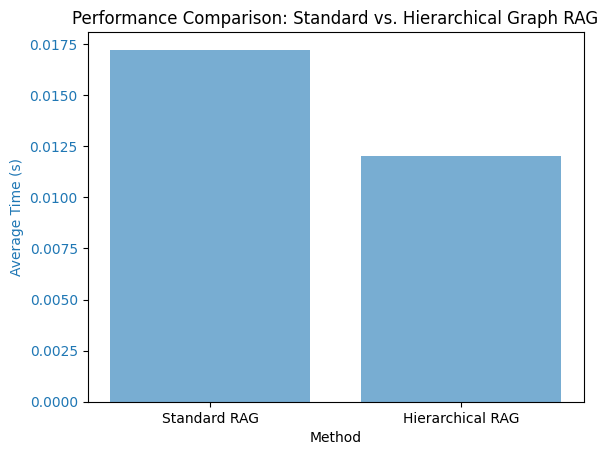

In [15]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from time import time

def evaluate(data, G, retrieval_function):
    total_time = 0

    # Generate embeddings for each question in batch
    questions = [q["question"] for q in data]
    question_embeddings = model(**tokenizer(questions, return_tensors='pt', truncation=True, padding=True)).last_hidden_state.mean(dim=1)

    for i, question_embedding in enumerate(question_embeddings):
        start = time()
        retrieved_index = retrieval_function(G, question_embedding)
        end = time()
        total_time += (end - start)

    avg_time = total_time / len(data)
    return avg_time

# Sample questions to evaluate performance
data = [
    {"question": "What is artificial intelligence?"},
    {"question": "Explain deep learning."},
    {"question": "What is reinforcement learning?"}
]

# Evaluate both models
avg_time_standard = evaluate(data, G, retrieve_standard)
avg_time_hierarchical = evaluate(data, G, retrieve_hierarchical)

# Print evaluation results
print("Standard RAG - Average Time:", avg_time_standard)
print("Hierarchical RAG - Average Time:", avg_time_hierarchical)

# Plot the performance comparison
labels = ['Standard RAG', 'Hierarchical RAG']
times = [avg_time_standard, avg_time_hierarchical]

fig, ax1 = plt.subplots()

# Time Plot
ax1.set_xlabel('Method')
ax1.set_ylabel('Average Time (s)', color='tab:blue')
ax1.bar(labels, times, color='tab:blue', alpha=0.6, label='Time')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title("Performance Comparison: Standard vs. Hierarchical Graph RAG")
plt.show()